In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import powerlaw

# The network of philosophers



The following notebook has the scope to build the **network of the philosophers**, a network to visualize the relations between philosophers.

## Motivation

The network of the philosophers  is a directed graph that aims to explain how the philosophers of the past and the present are connected between each others in order to find patterns in the thougths, in the fields of interest (topics), nationalities. In other workds, this network represents a tool to visualize from different perspectives the information about the philosophers, and transform the process of learning about philosophy in a proactive and interactive way than the simply *reading a book*. 

## Description of the graph

The mathematical object *graph* offers a way to explore the way some entities - the *nodes* (in our case the **philosophers**) are connected among each others. In this network , a philosopher *a* is linked to a philosopher *b* if in the wikipedia page of *a* there is a **link** pointing to the page of *b*. The concept of exploiting the web links in order to build the edges if the graph is a based on a solid assumption: a *link* between two philosophers can be considered a relevant connection in the sense that, with a good probability, the two philosophers have something in common (such as thought, ploitical party, ideas, field of research ...).

Different attributes are add to the network in order to analyze how the the connections between the philosophers reflects on other aspects of the philosophers.

## Data collection

The datasets used in this notebook are taken from the data preprocessed in the notebook `DataPreparation.ipynb`, that can be found in the [GitHub repository](https://github.com/aristofanischionis/PhilosophersPageNotebook). The datasets are merged on the name of the file with the wikipedia page in the resulting dataset *df*. Then, only the relevant columns are taken.

In [2]:
path_git = "C://Users//ALESSANDRO//Downloads//SocialGraphsPhilosophersProject-main//SocialGraphsPhilosophersProject-main//"
path = "C://Users//ALESSANDRO//Desktop//Social Graphs and interactions//project//"
# Load dataset of the philosophers with centuries
df = pd.read_csv(path_git+"philosophers_with_centuries.csv")

# load and preprocess dataset with tagwords
df_tag = pd.read_csv(path+"tagwords.csv")

df_tag["File name"] = df_tag["philosopher"]
df_tag = df_tag[['Unnamed: 0', 'File name', 'text', 'preprocess_text', 'text_clean','tag']]

# load and preprocess dataset with nationalities
df_nationalities = pd.read_csv(path+"nationalities.csv")

df_nationalities["File name"] = df_nationalities["philosopher"]

# # merge the two datasets
df = pd.merge(df, df_tag, on='File name')
df = pd.merge(df, df_nationalities, on='File name')

df = df[["File name", "Name", "century", "text_x", "preprocess_text_x", "text_clean_x", "tag", "nationality"]]
df.head()

,File name,Name,century,text_x,preprocess_text_x,text_clean_x,tag,nationality
0,Aaron_Ben-Ze'ev.txt,Aaron Ben-Ze'ev,20,"[(""Aaron Ben-Ze'ev"", "" ('''אהרון בן-זאב'''; bo...",is an israeli philosopher. he was president o...,israeli president university haifa 2004 2012,"['university', 'president']",israeli
1,Abd_al-Latif_al-Baghdadi.txt,Abd al-Latif al-Baghdadi,12,"[('ʿAbd al-Laṭīf al-Baghdādī', "" ({{lang-ar|عب...",", short for , was a physician, philosopher, h...",short physician historian grammarian traveler ...,[],arabic
2,Abdolkarim_Soroush.txt,Abdolkarim Soroush,20,"[('Abdolkarim Soroush', "" ({{lang|fa|عبدالكريم...",", is an iranian islamic thinker, reformer, rum...",iranian islamic thinker reformer rumi scholar ...,"['university', 'professor', 'scholar', 'influe...",iranian
3,Abdullah_Laroui.txt,Abdullah Laroui,20,"[('Abdallah Laroui', "" ({{lang-ar|عبدالله العر...","is a moroccan philosopher, historian, and nov...",moroccan historian novelist work philosophical...,"['philosophical', 'written']",arab
4,Abdullah_al-Qasemi.txt,Abdullah al-Qasemi,20,"[('Abdullah al-Qasemi', ' (1907 – 9 January 1...",was a saudi arabian 20th-century writer and ...,saudi arabian 20thcentury writer intellectual ...,"['writer', 'world', 'god']",arab


In [3]:
print("The node has ", len(df), " rows.")

The node has  1732  rows.


## Building a digraph with of all the philosophers

The following function is created in order to build a digraph with all the philosophers in the rows. First, the graph will be not connected. Afternwards, the edges will be added upon the links in the wikipedia pages.

In [4]:
import networkx as nx
import os

def create_digraph_with_philosophers(df):
    """Create NetworkX' Digraph with isolated nodes. 
    Each node represents a philosopher.

    Parameters
    ----------
    philosophers_df : pandas.DataFrame
        DataFrame containing column `Name` values of which will become identifiers of nodes

    Returns
    ----------
    NetworkX.DiGraph
        A DiGraph with isolated nodes representing philosophers from provided DataFrame
    """
    G = nx.DiGraph()
    G.add_nodes_from([row['Name'] for _, row in df.iterrows()])
    return G

In [5]:
G = create_digraph_with_philosophers(df)
print("Created graph with %d nodes and %d edges" % (G.number_of_nodes(), G.number_of_edges()))

Created graph with 1732 nodes and 0 edges


With a regular expression, all the links are taken from the the wikipedia pages of the philosophers. The links are marked in the wikipedia page in the format `[*text*|*text*]`, hence they are extracted with the following pattern:

`/\/[/\/[(.*?)(?:\|.*?)?(?:#.*?)?\]\]`

that has already been used in the class (*Social Graphs and interactions*). The pattern is implemented inside the function `find_all_links_on_page`.

In [6]:
import re

def find_all_links_on_page(file_path):
    """Given a file to text path, finds all internal Wiki links

    Parameters
    ----------
    file_path : str
        Path to the text file from which we want to extract links

    Returns
    ---------
    list<str>
        List of links
    
    """
    with open(file_path, "r", encoding="utf-8") as f:
        # Read file
        page_content = f.read()

        # Find all links with regex
        pattern = r"\[\[(.*?)(?:\|.*?)?(?:#.*?)?\]\]"
        return re.findall(pattern, page_content)

Eventually, function defined above is used in the following script to build the graph.

In [7]:
philosophers_pages_root = path+"philosophers_pages"
for _, row in df.iterrows():
    linked_page_names = find_all_links_on_page("%s/%s" % (philosophers_pages_root, row['File name']))
    for linked_page_name in linked_page_names:
        if linked_page_name in G:
            G.add_edge(row['Name'], linked_page_name)

print("Now graph G has %d nodes and %d edges" % (G.number_of_nodes(), G.number_of_edges()))

Now graph G has 1732 nodes and 14103 edges


## Removing isolated nodes

In [8]:
print("There are %d isolated nodes in G" % len(list(nx.isolates(G))))

There are 124 isolated nodes in G


In [9]:
G.remove_nodes_from(list(nx.isolates(G)))
print("Now graph G has %d nodes and %d edges" % (G.number_of_nodes(), G.number_of_edges()))

Now graph G has 1608 nodes and 14103 edges


# Basic statistics of the graph

The following function allow to find some information about the nodes of the graph, in order to have a first overview of the graph built so far, and in particular to see which are the most crucial nodes of the graph. These will be probably the most important philosophers in the history, or at least those with the longest wikipedia pages.

In [10]:
def find_most_connected_nodes(G, n):
  """Given a node G, find n most connected nodes in terms of
  degree, in-degree and out-degree

  Parameters
  ----------
  G : nx.DiGraph
    DiGraph to be analyzed
  n : int
    Number of top connected nodes to be returned

  Returns
  ----------
  (list<(string, int)>, list<(string, int)>, list<(string, int)>) 
    A triplet with 3 lists, each list containing n tuples consisting of 
    a name of a character and a number of connections he/she has, corresponding
    to the n top connected characters.
    First list contains results in terms of undirected graph, second list in
    terms of in-degrees, and thirs list in terms of out-degrees.
  """
  return (
      sorted(G.degree, key=lambda x: x[1], reverse=True)[:n],
      sorted(G.in_degree, key=lambda x: x[1], reverse=True)[:n],
      sorted(G.out_degree, key=lambda x: x[1], reverse=True)[:n]
  )

In [11]:
# Top 10 connected allies 
top_connected_philosophers = find_most_connected_nodes(G, 10)

# Print results
print("10 top connected philosophers in undirected network:\n  - %s" 
      % "\n  - ".join(["%s: degree: %d" % tuple for tuple in top_connected_philosophers[0]]))

print("\n10 top connected philosophers in terms of in-degree:\n  - %s" 
      % "\n  - ".join(["%s: degree: %d" % tuple for tuple in top_connected_philosophers[1]]))

print("\n10 top connected philosophers in terms of out-degree:\n  - %s" 
      % "\n  - ".join(["%s: degree: %d" % tuple for tuple in top_connected_philosophers[2]]))

10 top connected philosophers in undirected network:
  - Aristotle: degree: 360
  - Immanuel Kant: degree: 354
  - Plato: degree: 333
  - Friedrich Nietzsche: degree: 234
  - Karl Marx: degree: 231
  - Georg Wilhelm Friedrich Hegel: degree: 222
  - David Hume: degree: 198
  - Bertrand Russell: degree: 179
  - Martin Heidegger: degree: 173
  - René Descartes: degree: 173

10 top connected philosophers in terms of in-degree:
  - Aristotle: degree: 319
  - Immanuel Kant: degree: 279
  - Plato: degree: 255
  - Karl Marx: degree: 187
  - Friedrich Nietzsche: degree: 150
  - David Hume: degree: 140
  - Georg Wilhelm Friedrich Hegel: degree: 133
  - Bertrand Russell: degree: 127
  - John Locke: degree: 127
  - René Descartes: degree: 125

10 top connected philosophers in terms of out-degree:
  - Georg Wilhelm Friedrich Hegel: degree: 89
  - Friedrich Nietzsche: degree: 84
  - Plato: degree: 78
  - Immanuel Kant: degree: 75
  - Leo Strauss: degree: 64
  - Martin Heidegger: degree: 63
  - Edmun

From the output it can be noticed that in general, the number of in-degree is much higher than the number of out degree. Moreover, the 10 top connected philosophers in terms of out degree are completely different than the most connected philosophers in terms of out degree. It follows that the top 10 connected philosophers (overall) are also the top 10 connected philosophers in terms of in degree, that are, in the end, can be considered - at least according to the model proposed in this project - **the most important philosophers of the history.**

Plotting the degree distribution it is also possible to have information about all the philosophers, and not only the most important. The plots of the degree distribution gives information about the number of connections of the nodes of the graph, and hence it aims to find a measure of the density of the network.

The plots of the degree distribution are displayed exploiting the function `plot_degree_distribution`:

In [12]:
sns.set_style('darkgrid')

def plot_degree_distribution(degrees, type_of_degree):
    """Plots degree distribution given list of degrees of every node in network
    
    Parameters
    ----------
    degrees : list<int>
        List of number of degrees per every node in the network
    type_of_degree : str
        Degree/In-degree/Out-degree: used in plot's title and axis names
    """
    hist_x, hist_y = np.unique(degrees, return_counts=True)

    plt.figure(figsize=(15,8))
    plt.suptitle("%s distribution" % type_of_degree)
    plt.subplot(2,2,1)

    ax1 = sns.histplot(data=degrees, binwidth=1)
    ax1.set(title="Histogram of the %s distribution" % type_of_degree.lower(), xlabel=type_of_degree, ylabel="Frequency")

    plt.subplot(2,2,2)
    ax2 = sns.scatterplot(x=hist_x, y=hist_y)
    ax2.set(xscale='log', yscale='log', xlabel=type_of_degree, ylabel="Frequency", title="%s distribution (Log-Log)" % type_of_degree)
    ax2.set_ylim(bottom=0.5, top=10e2)
    ax2.set_xlim(left=0.5, right=1000)
    plt.show()

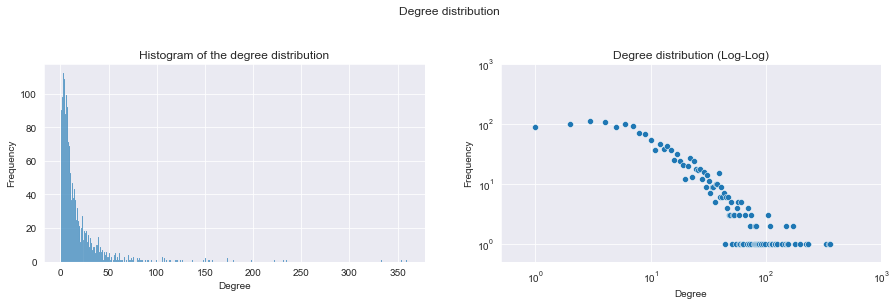

In [13]:
degrees = [G.degree(n) for n in G.nodes()]
plot_degree_distribution(degrees, "Degree")

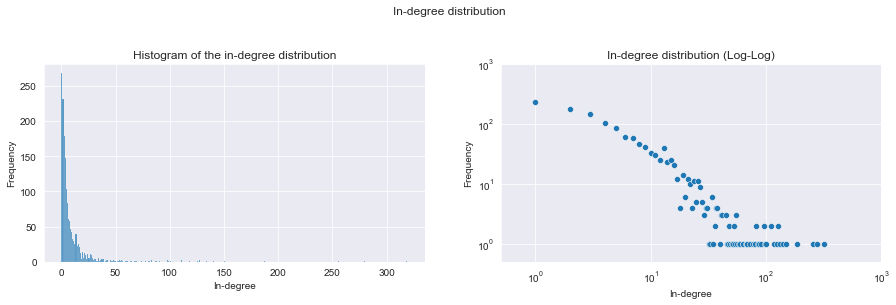

In [14]:
in_degrees = [G.in_degree(n) for n in G.nodes()]
plot_degree_distribution(in_degrees, "In-degree")

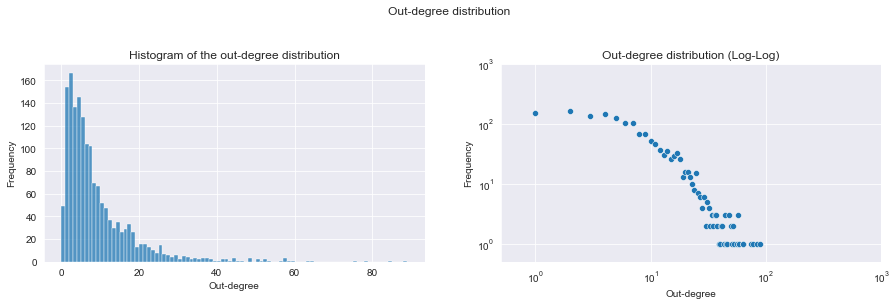

In [15]:
out_degrees = [G.out_degree(n) for n in G.nodes()]
plot_degree_distribution(out_degrees, "Out-degree")

The histgorams describing the in-degree and out-degree distribution give interesting information about the way the nodes of the graph are connected with among each others. It can be observed that the two plots have the shape that approximate two negative binomial distributions, the difference is that the in-degree distribution is scaled, and the values are doubled. The logaritmic scaled plot highlights how the distributions have the same shape.

## Exponent of the degree distribution

In [16]:
result = powerlaw.Fit([G.in_degree(node) for node in G.nodes() if G.in_degree(node) > 0]).alpha
print("Exponent of the in-degree distribution: %s" % result)

result = powerlaw.Fit([G.out_degree(node) for node in G.nodes() if G.out_degree(node) > 0]).alpha
print("Exponent of the out-degree distribution: %s" % result)

Calculating best minimal value for power law fit
Exponent of the in-degree distribution: 2.61933413314089
Calculating best minimal value for power law fit
Exponent of the out-degree distribution: 3.5217826946978343


# Visualisation of the network

In [17]:
# Convert DiGraph to Graph
H = G.to_undirected()

In [18]:
from fa2 import ForceAtlas2

sns.set_style('white')

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,

    # Performance
    jitterTolerance=0.1,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=2,

    # Tuning
    scalingRatio=0.1,
    strongGravityMode=False,
    gravity=0.1,

    # Log
    verbose=True
)

positions = forceatlas2.forceatlas2_networkx_layout(H, pos=None, iterations=2000)

# plt.figure(figsize=(15,15))
# nodes = H.nodes()
# edges = H.edges()
# nx.draw_networkx(H,
#                   positions,
#                   node_size=[H.degree(node) * 5 for node in H.nodes()],
#                   with_labels=False)
# plt.show()

100%|██████████| 2000/2000 [00:42<00:00, 47.39it/s]

BarnesHut Approximation  took  11.96  seconds
Repulsion forces  took  26.50  seconds
Gravitational forces  took  0.33  seconds
Attraction forces  took  0.48  seconds
AdjustSpeedAndApplyForces step  took  1.55  seconds


<!-- # Visualisation with Bokeh -->

In [19]:
from fa2 import ForceAtlas2
from bokeh.io import save
from bokeh.models import Range1d, Circle, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8
from bokeh.transform import linear_cmap
from bokeh.themes import Theme
from bokeh.plotting import figure, curdoc
from bokeh.palettes import Plasma10
from bokeh.palettes import Plasma8
from bokeh.palettes import Spectral4
from bokeh.palettes import Plasma10
from bokeh.palettes import RdYlGn
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes


curdoc().theme = Theme(filename=path+"bokeh_theme.yaml")

In [21]:
#Choose a title!
title = 'Philosophers_Network'

degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)
nx.set_node_attributes(G, name='size', values={d: int(degrees[d]/10) + 1 for d in degrees.keys()})

size_by_this_attribute = 'size'
color_by_this_attribute = 'degree'

color_palette = Plasma8

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Philosopher", "@index"), ("Degree", "@degree")]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-240, 280), y_range=Range1d(-200, 200), toolbar_location=None,
             plot_width=1250, plot_height=600)

# Turn off ticks ######################################################################################################
plot.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
plot.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

plot.yaxis.major_tick_line_color = None  # turn off y-axis major ticks
plot.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks

plot.xaxis.major_label_text_font_size = '0pt'  # turn off x-axis tick labels
plot.yaxis.major_label_text_font_size = '0pt'  # turn off y-axis tick labels
######################################################################################################################


#Create a network graph object with spring layout
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, positions, scale=1, center=(0, 0))


#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.05, line_width=0.3)

#Add network graph to the plot
plot.renderers.append(network_graph)

from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes

network_graph.node_renderer.selection_glyph = Circle(
   size = 25,
   fill_color = Spectral4[2]
)
network_graph.node_renderer.hover_glyph = Circle(
   size = 20,
   fill_color = Spectral4[1]
)

# network_graph.edge_renderer.glyph = MultiLine(
#    line_color = "#CCCCCC",
#    line_alpha = 0.8,
#    line_width = 3
# )
network_graph.edge_renderer.selection_glyph = MultiLine(
   line_color = Spectral4[2],
   line_width = 7
)
network_graph.edge_renderer.hover_glyph = MultiLine(
   line_color = Spectral4[1],
   line_width = 5
)


network_graph.selection_policy = NodesAndLinkedEdges()
# network_graph.inspection_policy = EdgesAndLinkedNodes()

plot.renderers.append(network_graph)

plot.background_fill_alpha = 0

save(plot, filename=f"{title}.html")

'C:\\Users\\ALESSANDRO\\Desktop\\Social Graphs and interactions\\project\\Philosophers_Network.html'

In [102]:
# INSERT IMAGE

The plot displayed with bokeh allows to interactively visualize the relations between the philosophers. The colours of the plot are based on the degree of the node: the greater is the degree of a node, the lighter is his color (the nodes with the largest amount of links are coloured in yellow). The size of the circle used as a node is also proportional to the degree of the node.

The network built in this way gives interesting insights about the distribution of the nodes and the way they are connected, providing information about the importance of a node. However, it is hard to come out with other relevant insights to understand with whom is really linked each philosopher. 

In order to go deeper in the matter, some features will be added to the network in the form of attributes that will be used in order to charachterize the neighbours of each node.

In the following section the plot that has been showed above will be coloured based on the nationality of the philosophers.

## Analysis of the nationalities

### Motivations

The nationality of a philosopher plays a relevant role, since it influences his thoughts as much as the fields of interest. Moreover, it can be supposed that through the visualization of the nodes, coloured by nations, it is possible to find patterns and clusters in the colors. For instance, it can be expected that the from the same nationality will have most of their connections between each others, or that the greek philosophers will have a lot of connections with ancient roman philosophers and writers.

### The network

The network that will be involved in the analysis is a subnetwork of *The network of Philosophers*. In fact, not all the philosophers in the dataset have an assigned nationality, either because it was not stated in the introduction page, or because the nationality of that philosopher was not included in the set of nationalities, because it was a minor and not relevant to the scope of the analysis. Furthermore, it has been decided not to include all the nationalities, but only a subset of n = 10 nationalities, in order to avoid dispersion of informations: it is more interesting to analyze a small but significant dataset, than a larger but less relevant. A too large amount of nationalities would mean having too many colors in the visualization and it may affect the analysis.

This is possible since , as it has already been mentioned in the data exploration, the distribution of the nationalities follows the *pareto principle*, therefore most of the philosophers will be taken into account only considering those nationalities.

### Analysis of the countries

First the distribution of the considered countries is displayed in the following block of code:

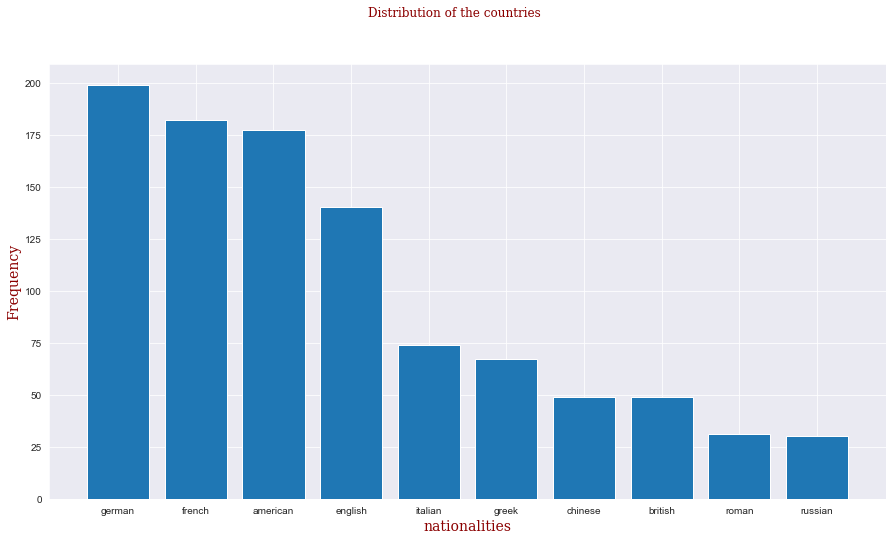

In [22]:
a = df.groupby("nationality").count()["Name"].sort_values(ascending=False)[:10] # top 10 most popolous nationalities in the dataset of the philosophers

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 14,
        }

font_title = {'family': 'serif',
              'color':  'black',
              'weight': 'normal',
              'size': 6,
            }

sns.set_style('darkgrid')

plt.figure(figsize=(15,8))
plt.suptitle("Distribution of the countries", fontdict=font)
plt.bar(a.index, a.values)
plt.xlabel("nationalities", fontdict=font)
plt.ylabel("Frequency", fontdict=font)
plt.show()

In [23]:
print("the subgraph containing only the philosophers belonging to the ten nationalities has ", df[df.nationality.isin(a.index)].shape[0], " nodes")

the subgraph containing only the philosophers belonging to the ten nationalities has  998  nodes


### Preparation of the dataset and creation of the network

In [24]:
focus_nat = list(df.groupby("nationality").count()["Name"].sort_values(ascending=False)[:10].index)
focus_nat

['german',
 'french',
 'american',
 'english',
 'italian',
 'greek',
 'chinese',
 'british',
 'roman',
 'russian']

In [25]:
df_top_nat = df[df.nationality.isin(focus_nat)]
df_top_nat.shape[0]

998

In [26]:
N = create_digraph_with_philosophers(df_top_nat)
print("Created graph with %d nodes and %d edges" % (N.number_of_nodes(), N.number_of_edges()))

Created graph with 998 nodes and 0 edges


In [27]:
philosophers_pages_root = path+"philosophers_pages"
for _, row in df_top_nat.iterrows():
    linked_page_names = find_all_links_on_page("%s/%s" % (philosophers_pages_root, row['File name']))
    for linked_page_name in linked_page_names:
        if linked_page_name in N:
            N.add_edge(row['Name'], linked_page_name)

print("Now graph N has %d nodes and %d edges" % (N.number_of_nodes(), N.number_of_edges()))

Now graph N has 998 nodes and 5657 edges


## Basic stats of the network

The following plots are pretty much the same as those seen about *the network of the philosophers*, with the only difference that the frequency is lower, since the nodes beloning to the subgraph are few more than a half.

Noth the histograms show that also the frequency is roughly a half than the frequency of the degree seen for the super graph.

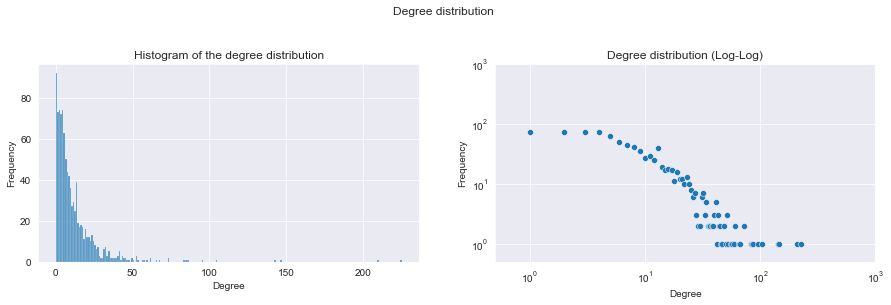

In [28]:
degrees = [N.degree(n) for n in N.nodes()]
plot_degree_distribution(degrees, "Degree")

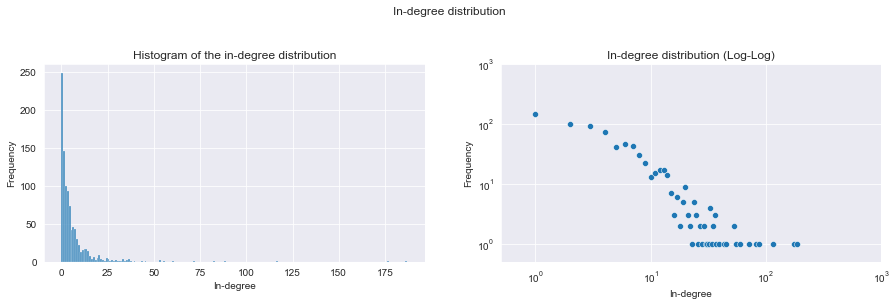

In [29]:
in_degrees = [N.in_degree(n) for n in N.nodes()]
plot_degree_distribution(in_degrees, "In-degree")

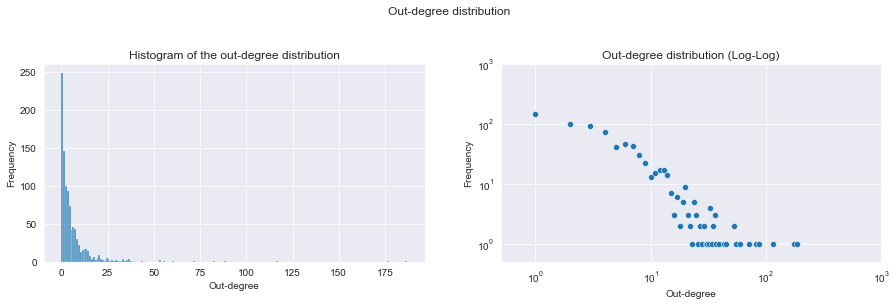

In [30]:
out_degrees = [N.in_degree(n) for n in N.nodes()]
plot_degree_distribution(out_degrees, "Out-degree")

## Exponent of the degree distribution

In [31]:
result = powerlaw.Fit([N.in_degree(node) for node in N.nodes() if N.in_degree(node) > 0]).alpha
print("Exponent of the in-degree distribution: %s" % result)

result = powerlaw.Fit([N.out_degree(node) for node in N.nodes() if N.out_degree(node) > 0]).alpha
print("Exponent of the out-degree distribution: %s" % result)

Calculating best minimal value for power law fit
Exponent of the in-degree distribution: 2.802595991937793
Calculating best minimal value for power law fit
Exponent of the out-degree distribution: 3.7997274215021775


The exponent degree of the distribution of the subgrap is also very close to the distribution of the initial graph.

### Isolated nodes removal

In [32]:
print("There are %d isolated nodes in N" % len(list(nx.isolates(N))))

There are 92 isolated nodes in N


In [33]:
N.remove_nodes_from(list(nx.isolates(N)))
print("Now graph N has %d nodes and %d edges" % (N.number_of_nodes(), N.number_of_edges()))

Now graph N has 906 nodes and 5657 edges


### Building the sub network of the philosophers

In order to color the nodes of the graph, according to the nationality, to each of the 10 nationalities is associated a code, that is an integer number between 1 and 10: a different color will be associated to each of the codes.

In [34]:
# convert countries to numerical values (creating new column)
cat_col = []
for i in df_top_nat["nationality"]:
    for jth in range(len(focus_nat)):
#         print(jth)
        if i == focus_nat[jth]:
            cat_col.append(jth)

df_top_nat["code_color"] = cat_col

<ipython-input-34-d0e47669ae1e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_nat["code_color"] = cat_col


In [35]:
df_top_nat[["Name", "nationality", "code_color"]].head()

,Name,nationality,code_color
8,Abraham Joshua Heschel,american,2
9,Abraham Tucker,english,3
22,Adolf Reinach,german,0
23,Adolf von Harnack,german,0
25,Aenesidemus,greek,5


The attribute `code_color` is add to each node of the network. This attribute will be used to map the color of the nodes in the interactive visualization.

In [36]:
nx.set_node_attributes(N, {df_top_nat["Name"][d]:{"code_color":df_top_nat["code_color"][d]} for d in df_top_nat.index})

In [38]:
#Choose a title!
title = 'Philosophers_Network_by_country'

# set positions
# positions = forceatlas2.forceatlas2_networkx_layout(N, pos=None, iterations=2000)

degrees = dict(nx.degree(N))
nx.set_node_attributes(N, name='degree', values=degrees)
nx.set_node_attributes(N, name="code_color", values={df_top_nat["Name"][d]: df_top_nat["code_color"][d] for d in df_top_nat.index})
nx.set_node_attributes(N, name="nationality", values={df_top_nat["Name"][d]: df_top_nat["nationality"][d] for d in df_top_nat.index})

nx.set_node_attributes(N, name='size', values={d: int(degrees[d]/7) + 3 for d in degrees.keys()})
size_by_this_attribute = 'size' 
color_by_this_attribute = 'code_color'

# color_palette = sns.color_palette("hls", len(focus_countries))

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Philosopher", "@index"), ("Degree", "@degree"), ("Nationality", "@nationality")]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-240, 280), y_range=Range1d(-200, 200), toolbar_location=None,
             plot_width=1450, plot_height=700)

# Turn off ticks ######################################################################################################
plot.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
plot.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

plot.yaxis.major_tick_line_color = None  # turn off y-axis major ticks
plot.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks

plot.xaxis.major_label_text_font_size = '0pt'  # turn off x-axis tick labels
plot.yaxis.major_label_text_font_size = '0pt'  # turn off y-axis tick labels
######################################################################################################################


#Create a network graph object with spring layout
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(N, positions, scale=1, center=(0, 0))


#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, Plasma10, minimum_value_color, maximum_value_color), line_width=0.1)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.07, line_width=0.5)

#Add network graph to the plot
plot.renderers.append(network_graph)


network_graph.node_renderer.selection_glyph = Circle(
   size = 25,
   fill_color = Spectral4[2]
)
network_graph.node_renderer.hover_glyph = Circle(
   size = 20,
   fill_color = Spectral4[1]
)


network_graph.edge_renderer.hover_glyph = MultiLine(
   line_color = Spectral4[2],
   line_width = 3,
)


network_graph.selection_policy = NodesAndLinkedEdges()
# network_graph.inspection_policy = EdgesAndLinkedNodes()

plot.renderers.append(network_graph)

plot.background_fill_alpha = 0

save(plot, filename=f"{title}.html")

'C:\\Users\\ALESSANDRO\\Desktop\\Social Graphs and interactions\\project\\Philosophers_Network_by_country.html'

### Comments about the nationality plot

As it was expected, the plot shows that there are some patterns in the graph, according to the data about the relations and the nationalities. The most relevant patterns that can be observed in the plot will be commented below.

First of all, it can be observed that most of the largest dots (i.e. most connected philosophers) are located in the center of the network and are coloured in dark violet. All of these philosophers are german, and they are located in the center of the network, since they have relationship - in general - with all the others nationalities. It is worth thinking that the german philosophers are linked pretty much to all the others nationalities, since the german philosophers, such as Kant, Marx, Hegel influenced a lot of philosophers, and were influenced by a lot of philosophers.

Among the german philosophers, it is worth looking in particular at marx - one of the dark violet nodes in the centre-left of the network (going with the cursor on the nodes it is possible to visualize the information about each node). Marx is positioned in the middle between german philosophers and russian philosopher. Marx - as a father of the communism - inspired a lot of russian writers and philosophers (marked in yellow and located in the bottom left side of the network).

Moreover, at the bottom left side there is a small group of isolated orange nodes. Those are the chinese philosophers, that have very small connections with philosophers other than chinese. The chinese philosophers did not influence massively any other cultures with their thoughts, hence they are linked between them, but isolated with respect to other countries.

In the top left side there are the classic philosophers: roman and greek. As already mentioned, the relationship between these two nationalities is indissoluble and the influences between group of philosophers remarkable. Most of the school of thoughts were shared betweem roman and greek, and the cultures were very close, also because the historical age is the same. For this reason they form a cloud of dark-yellow and dark-orange dots in the left.

Eventually on the right side of the plot british and american philosophers also form a clodud, that represent the anglo-saxon side of the philosophers.

### Conclusion

The project shows how much an analyzing a network can tell about a topic. The more information, attributes, and features are given to the network, the more are the insights that can be detected in terms of relations between entities.